# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import os
os.chdir('../../')

In [7]:
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [8]:
from src.music_transformer import *

In [9]:
from src.msklm import *

In [10]:
config = mlm_config(vocab);

In [11]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
numpy_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'multi_data_idxenc.pkl'

In [12]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## MSKLM

In [13]:
data = load_data(numpy_path, data_save_name, bs=1)
learn = mlm_model_learner(data, config.copy(), loss_func=MultiLoss())

In [14]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]

In [15]:
learn = learn.to_fp16()

## Load existing

In [16]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [17]:
load_path = saved_models[1]; load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

In [18]:
state = torch.load(load_path, map_location='cpu')
m = get_model(learn.model)
m.load_state_dict(state['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Set Loss

In [19]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid'),
 PosixPath('data/midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid'),
 PosixPath('data/midi/examples/Just Give Me A Reason - Pink - Chorus.mid'),
 PosixPath('data/midi/examples/All I Want For Christmas Is You - Mariah Carey - Pre-Chorus-And-Chorus.mid'),
 PosixPath('data/midi/examples/Fuer Elise - Ludwig Van Beethoven - Verse.mid'),
 PosixPath('data/midi/examples/Let It Go - Idina Menzel - Chorus.mid'),
 PosixPath('data/midi/examples/Call Me Maybe - Carly Rae Jepsen - Chorus.mid'),
 PosixPath('data/midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/midi/examples/A Thousand 

In [20]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [21]:
# Encode file 
x = midi2idxenc(file)
x_pos = neg_position_enc(x)

# Convert to tensor
x = torch.tensor(x)
x_pos = torch.tensor(x_pos)
if torch.cuda.is_available(): 
    x = x.cuda()
    x_pos = x_pos.cuda()

In [22]:
torch.device

torch.device

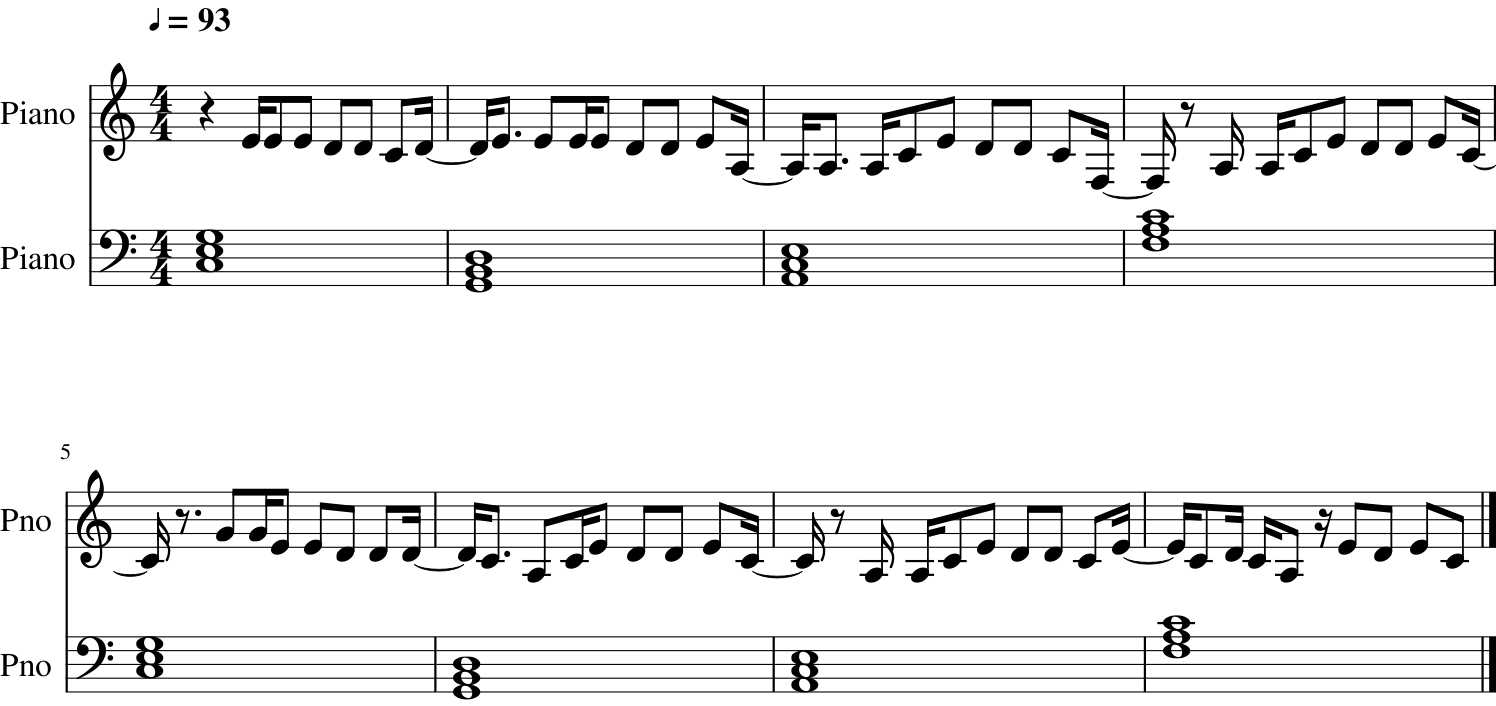

In [23]:
original_stream = file2stream(file)
original_stream.show()

In [24]:
original_stream.show('midi')

## Predict Mask

In [25]:

def predict_mask(self, x:Tensor, pos=None,
                temperatures:float=(1.0,1.0),
                top_k=20, top_p=0.8):
    x = x.clone().squeeze()
    y = torch.tensor([0])
    if pos is None:
        pos = torch.tensor(neg_position_enc(x.cpu().numpy()), device=x.device)
    self.model.reset()
    mask_idxs = (x == vocab.mask_idx).nonzero().view(-1)

    with torch.no_grad():
        for midx in progress_bar(mask_idxs, leave=True):

            # Using original positions, otherwise model gets too off track
    #         pos = torch.tensor(-position_enc(xb[0].cpu().numpy()), device=xb.device)[None]

            # Next Word
            res = self.pred_batch(batch=({ 'msk': { 'x': x[None], 'pos': pos[None] } }, y) )['msk'][0]
            res = F.softmax(res[midx], dim=-1) # task1, task2 - (bs x ts x vocab)

            # Don't allow any special tokens (as we are only removing notes and durations)
            res[vocab.bos_idx] = 0.
            res[vocab.sep_idx] = 0.
            res[vocab.stoi[EOS]] = 0

            # Use first temperatures value if last prediction was duration
            prev_idx = x[midx-1]
            temperature = temperatures[0] if self.data.vocab.is_duration(prev_idx) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()
            #         idx = res.argmax()

            x[midx] = idx

    return x.cpu().numpy()

#### Regenerate durations

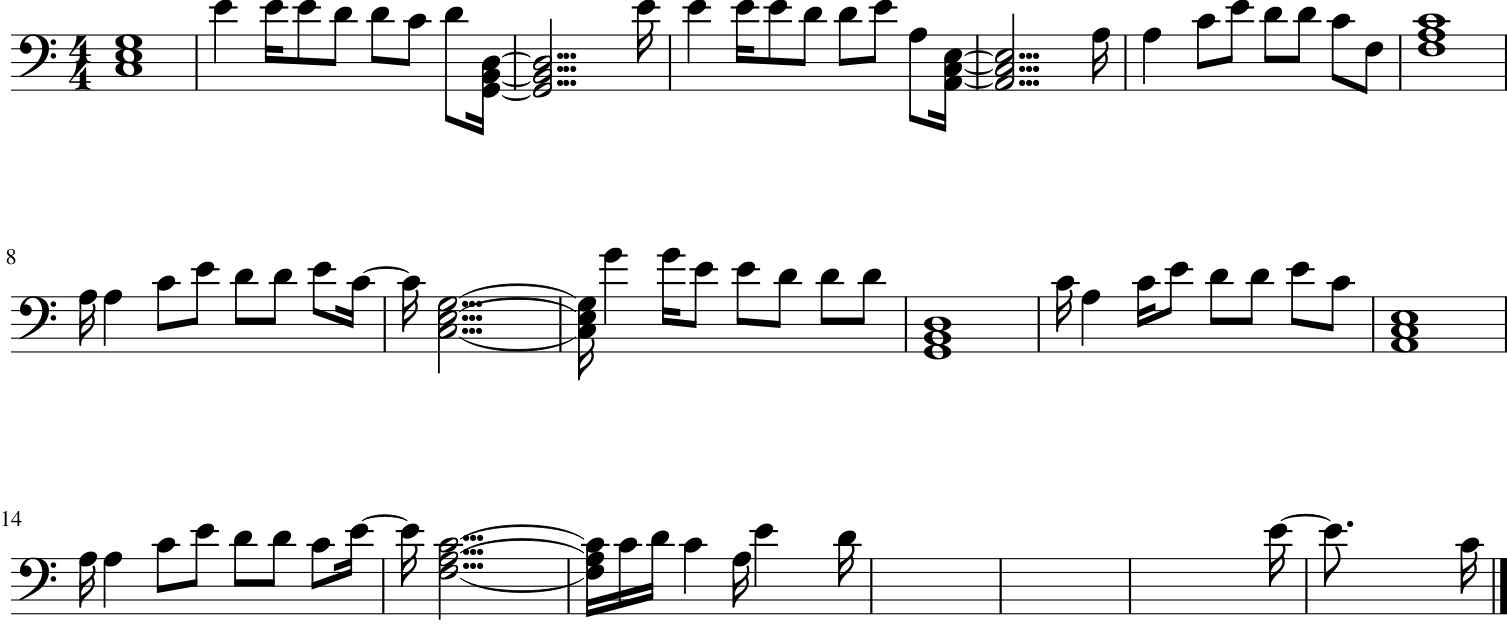

In [26]:
# duration mask
x_dur = mask_input(x, mask_range=vocab.dur_range)

# pred = learn.predict_mask(xb_dur, temperatures=(1.2,0.8))
# pred = learn.predict_mask(xb_dur, xb_pos, temperatures=(0.8,0.8), top_k=40, top_p=0.6)
pred = predict_mask(learn, x_dur, x_pos, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

stream_dur = idxenc2stream(pred)
stream_dur.show()

In [27]:
stream_dur.show('midi')

#### Regenerate Notes

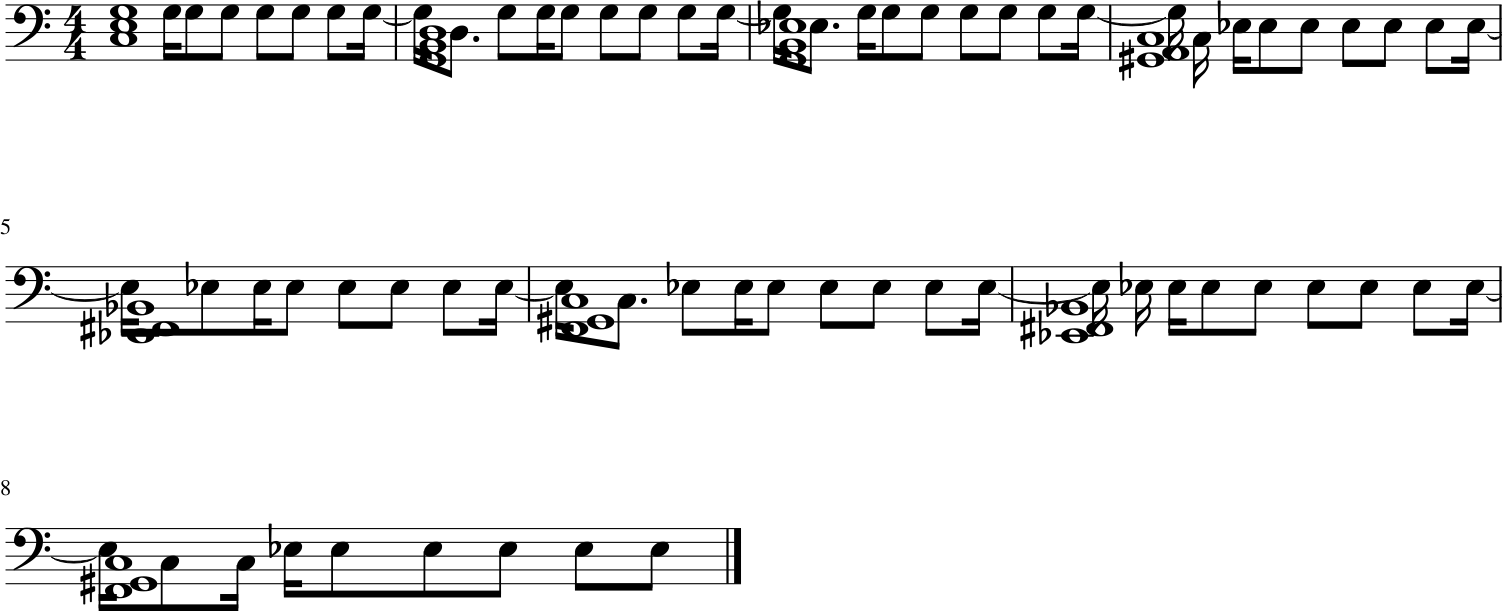

In [28]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
x_note = mask_input(x, mask_range=vocab.note_range)
pred_note = learn.predict_mask(x_note)

stream_note = idxenc2stream(pred_note)
stream_note.show()

In [29]:
vocab.textify(pred_note)

'xxbos xxpad n55 d16 n52 d16 n48 d16 xxsep d4 n55 d1 xxsep d1 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d1 n50 d16 n47 d16 n43 d16 xxsep d1 n50 d3 xxsep d3 n55 d2 xxsep d2 n55 d1 xxsep d1 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d1 n51 d16 n47 d16 n43 d16 xxsep d1 n51 d3 xxsep d3 n55 d1 xxsep d1 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d2 n55 d2 xxsep d1 n48 d16 n45 d16 n44 d16 xxsep d3 n48 d1 xxsep d1 n51 d1 xxsep d1 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d1 n46 d16 n42 d16 n39 d16 xxsep d4 n51 d2 xxsep d2 n51 d1 xxsep d1 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d1 n48 d16 n44 d16 n41 d16 xxsep d1 n48 d3 xxsep d3 n51 d2 xxsep d2 n51 d1 xxsep d1 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d2 n51 d2 xxsep d1 n46 d16 n42 d16 n39 d16 xxsep d3 n51 d1 xxsep d1 n51 

In [30]:
stream_note.show('midi')

In [31]:

def mask_predict_from_midi(learn, midi=None,
                           temperatures=(1.0,1.0), top_k=30, top_p=0.7, 
                           predict_notes=True, **kwargs):
    seed_np = midi2npenc(midi) # music21 can handle bytes directly
    x = torch.tensor(to_single_stream(seed_np))
    pos = torch.tensor(neg_position_enc(x.cpu().numpy()), device=x.device)
    mask_range = vocab.note_range if predict_notes else vocab.dur_range
    x_msk = mask_input(x, mask_range=mask_range)
    if torch.cuda.is_available(): 
        x_msk = x_msk.cuda()
        pos = pos.cuda()
    pred = learn.predict_mask(x_msk, pos, temperatures=temperatures, top_k=top_k, top_p=top_p)
    return pred

In [32]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

In [33]:
idxenc2stream(out).show()

IndexError: index 144 is out of bounds for axis 2 with size 128

## Prediction next word

In [34]:
seed_len = 4 # 4 beats = 1 bar
seed = seed_tfm(x, seed_len)

In [35]:
# seed_stream = npenc2stream(seed)
# seed_stream.show()

In [36]:
def predict_nw(self, x:Tensor, n_words:int=128,
                 temperatures:float=(1.0,1.0), min_bars=4,
                 top_k=30, top_p=0.6):
    "Return the `n_words` that come after `text`."
    self.model.reset()
    new_idx = []
    pos = torch.tensor(neg_position_enc(x.cpu().numpy()), device=x.device)
    last_pos = pos[-1]
    y = torch.tensor([0])

    sep_count = 0
    bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
    vocab = self.data.vocab

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):
            batch = { 'lm': { 'x': x[None], 'pos': pos[None] } }, y
            res = self.pred_batch(batch=batch)['lm'][-1][-1]
            res = F.softmax(res, dim=-1)

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[vocab.bos_idx] = 0.

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(new_idx)==0 or self.data.vocab.is_duration(new_idx[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()

            if new_idx and new_idx[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                sep_count += duration
                last_pos = last_pos - duration # position is negative

            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break

            new_idx.append(idx)
            x = x.new_tensor([idx])
            pos = pos.new_tensor([last_pos])
    return np.array(new_idx)

In [37]:
out = predict_nw(learn, seed, n_words=200)

In [38]:
# out = learn.predict_nw(seed, n_words=200)

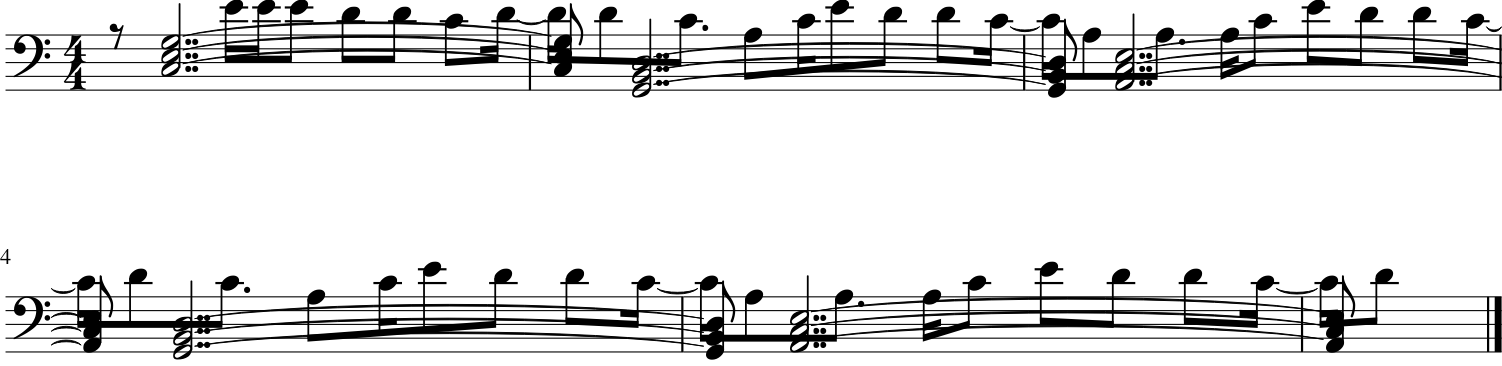

In [39]:
stream = idxenc2stream(out)
stream.show()

In [40]:
stream.show('midi')

In [41]:

def nw_predict_from_midi(learn, midi=None, n_words=600, 
                      temperatures=(1.0,1.0), top_k=30, top_p=0.6, seed_len=None, **kwargs):
    try:
        seed_np = midi2idxenc(midi) # music21 can handle bytes directly
        if seed_len is not None:
            seed_np = seed_tfm(seed_np, seed_len=seed_len)
    except IndexError:
        seed_np = to_single_stream(np.zeros((0, 2), dtype=int))
    x = torch.tensor(seed_np)
    if torch.cuda.is_available(): x = x.cuda()
    pred = learn.predict_nw(x, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    return np.concatenate((seed_np,pred), axis=0)

In [42]:
out = nw_predict_from_midi(learn, file, seed_len=4, top_k=30, top_p=0.5)

Predicted BOS token. Returning prediction...


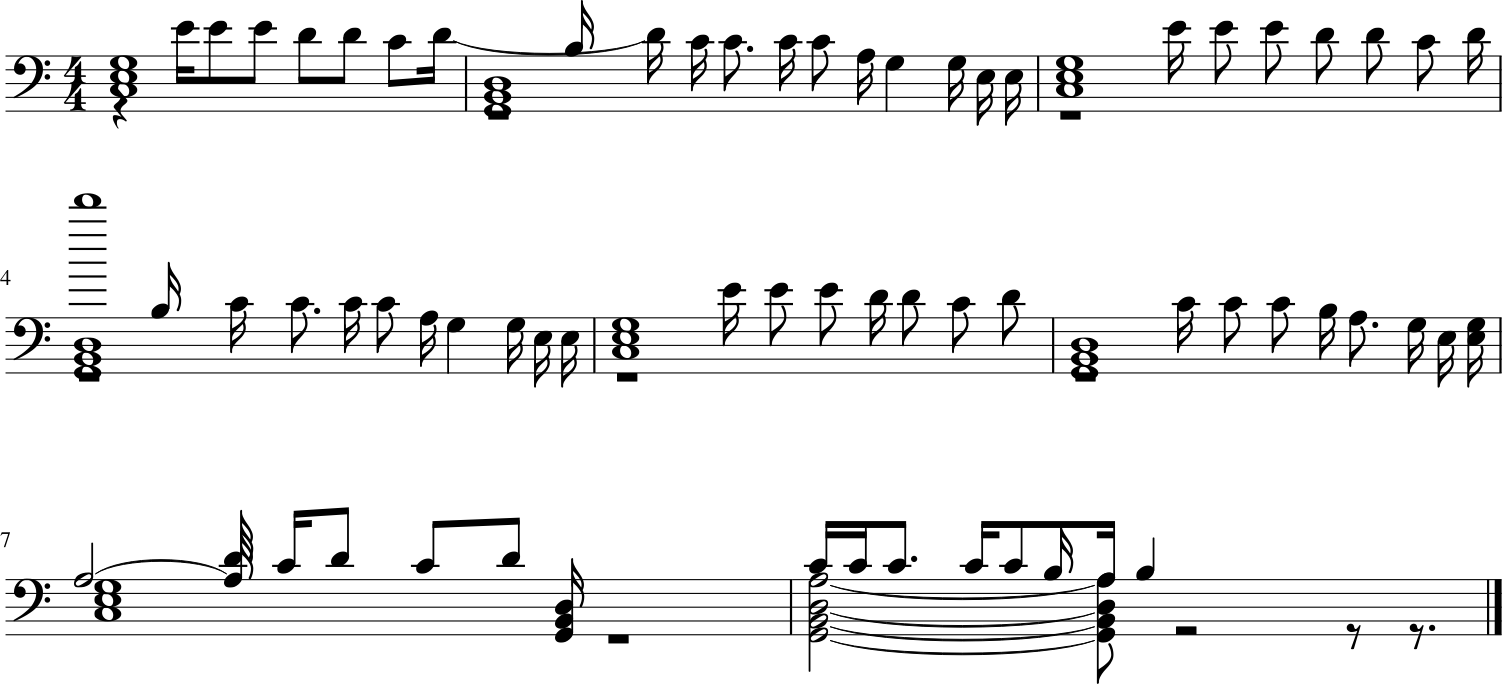

In [43]:
stream = idxenc2stream(out)
stream.show()

In [44]:
stream.show('midi')

## Predict Seq2Seq

In [45]:
def midi_extract_melody_chords(midi):
    stream = file2stream(midi) # 1.
    chordarr = stream2chordarr(stream) # 2.
    _,num_parts,_ = chordarr.shape

    if num_parts == 1:
        # if predicting melody, assume only track is chord track
        p1, p2 = part_enc(chordarr, 0), np.zeros((0,2), dtype=int)
        p1, p2 = (p2, p1) if pred_melody else (p1, p2)
    elif num_parts == 2:
        p1, p2 = [part_enc(chordarr, i) for i in range(num_parts)]
        p1, p2 = (p1, p2) if avg_pitch(p1) > avg_pitch(p2) else (p2, p1)
    else:
        raise ValueError('Could not extract melody and chords from midi file. Please make sure file contains exactly 2 tracks')
        
    mpart = partenc2seq2seq(p1, part_type=MSEQ)
    cpart = partenc2seq2seq(p2, part_type=CSEQ)
    return mpart, cpart

In [46]:

def predict_s2s(self, xb_msk:Tensor, xb_lm:Tensor, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=30, top_p=0.8):
    self.model.reset()

    x_lm = xb_lm.tolist()
    lm_pos = (neg_position_enc(xb_lm.cpu().numpy())).tolist()
    last_pos = lm_pos[-1]

    msk_pos = torch.tensor(neg_position_enc(xb_msk.cpu().numpy()), device=xb_msk.device)
    x_enc = self.model.encoder(xb_msk.view(1, -1), msk_pos.view(1, -1))

    max_pos = msk_pos[-1] - SAMPLE_FREQ * 4

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):

            # Next Word
            x, pos = torch.tensor(x_lm, device=xb_lm.device)[None], torch.tensor(lm_pos, device=xb_lm.device)[None]
            dec = self.model.decoder(x, pos, x_enc) # all tasks include mask decoding
            res = F.softmax(self.model.head(dec), dim=-1)[-1, -1]

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(x_lm)==0 or self.data.vocab.is_duration(x_lm[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()
            #         idx = res.argmax()

            if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
                print('Predicting BOS/EOS')
                break

            if x_lm and x_lm[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                last_pos = last_pos - duration # position is negative
                if last_pos < max_pos:
                    print('Predicted past counter-part length. Returning early')
                    break

            lm_pos.append(last_pos)
            x_lm.append(idx)

    return np.array(x_lm)

In [47]:
melody, chords = midi_extract_melody_chords(file)

## Predict melody

In [48]:
melody_cut = seed_tfm(melody, seed_len=3)

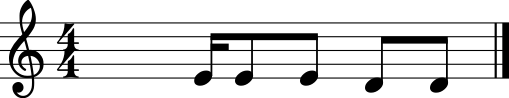

In [49]:
idxenc2stream(melody_cut).show()

In [50]:
xb_msk = torch.tensor(chords).cuda()
xb_lm = torch.tensor(melody_cut).cuda()

In [51]:
xb_msk.shape, xb_lm.shape

(torch.Size([65]), torch.Size([25]))

In [52]:
out = learn.predict_s2s(xb_msk, xb_lm)

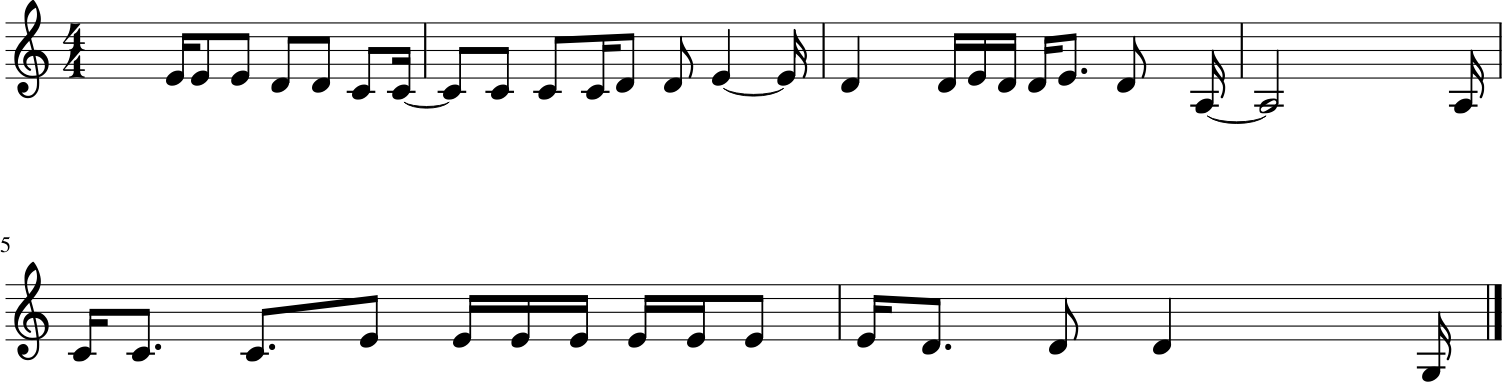

In [53]:
idxenc2stream(out).show()

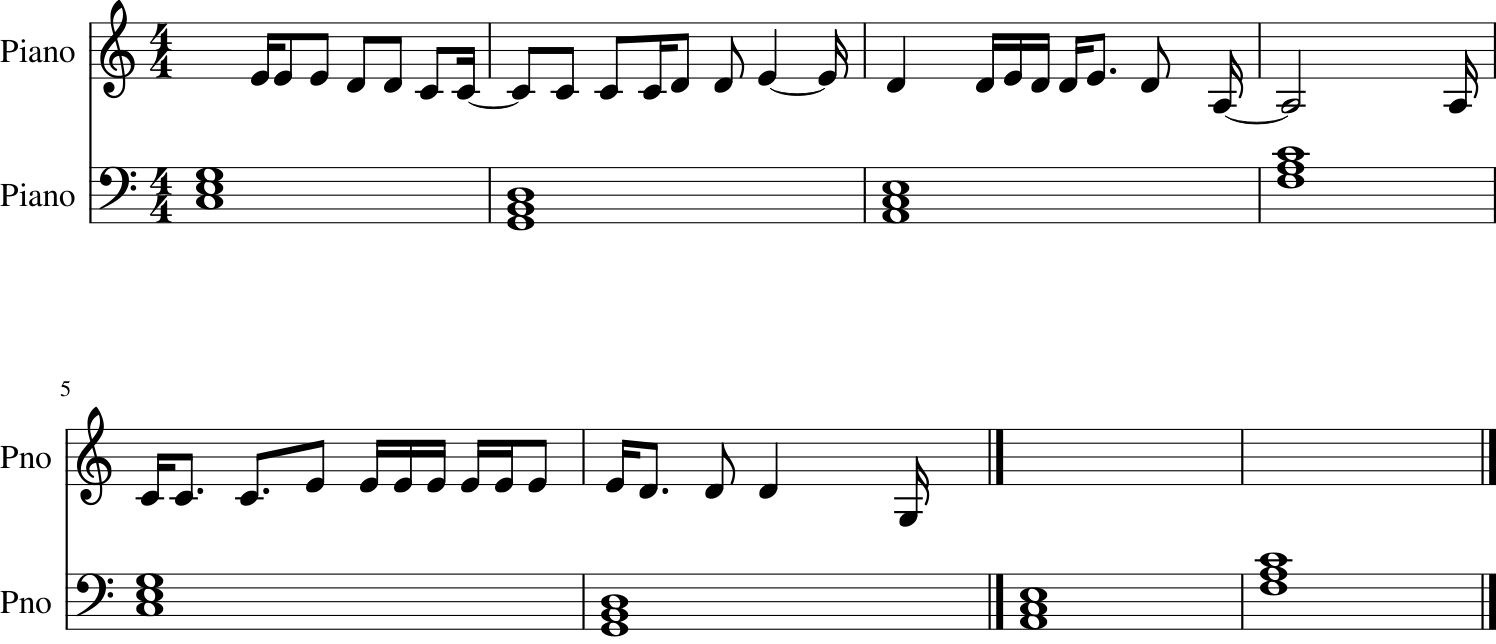

In [54]:
chordarr_comb = s2s_combine2chordarr(out, chords)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [55]:
comb_stream.show('midi')

## Predict chords

In [56]:
chord_cut = seed_tfm(chords, seed_len=3)

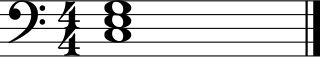

In [57]:
idxenc2stream(chord_cut).show()

In [58]:
xb_msk = torch.tensor(melody).cuda()
xb_lm = torch.tensor(chord_cut).cuda()

In [59]:
xb_msk.shape, xb_lm.shape

(torch.Size([251]), torch.Size([11]))

In [60]:
out = learn.predict_s2s(xb_msk, xb_lm)

Predicted past counter-part length. Returning early


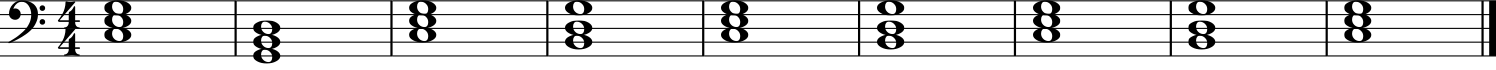

In [61]:
idxenc2stream(out).show()

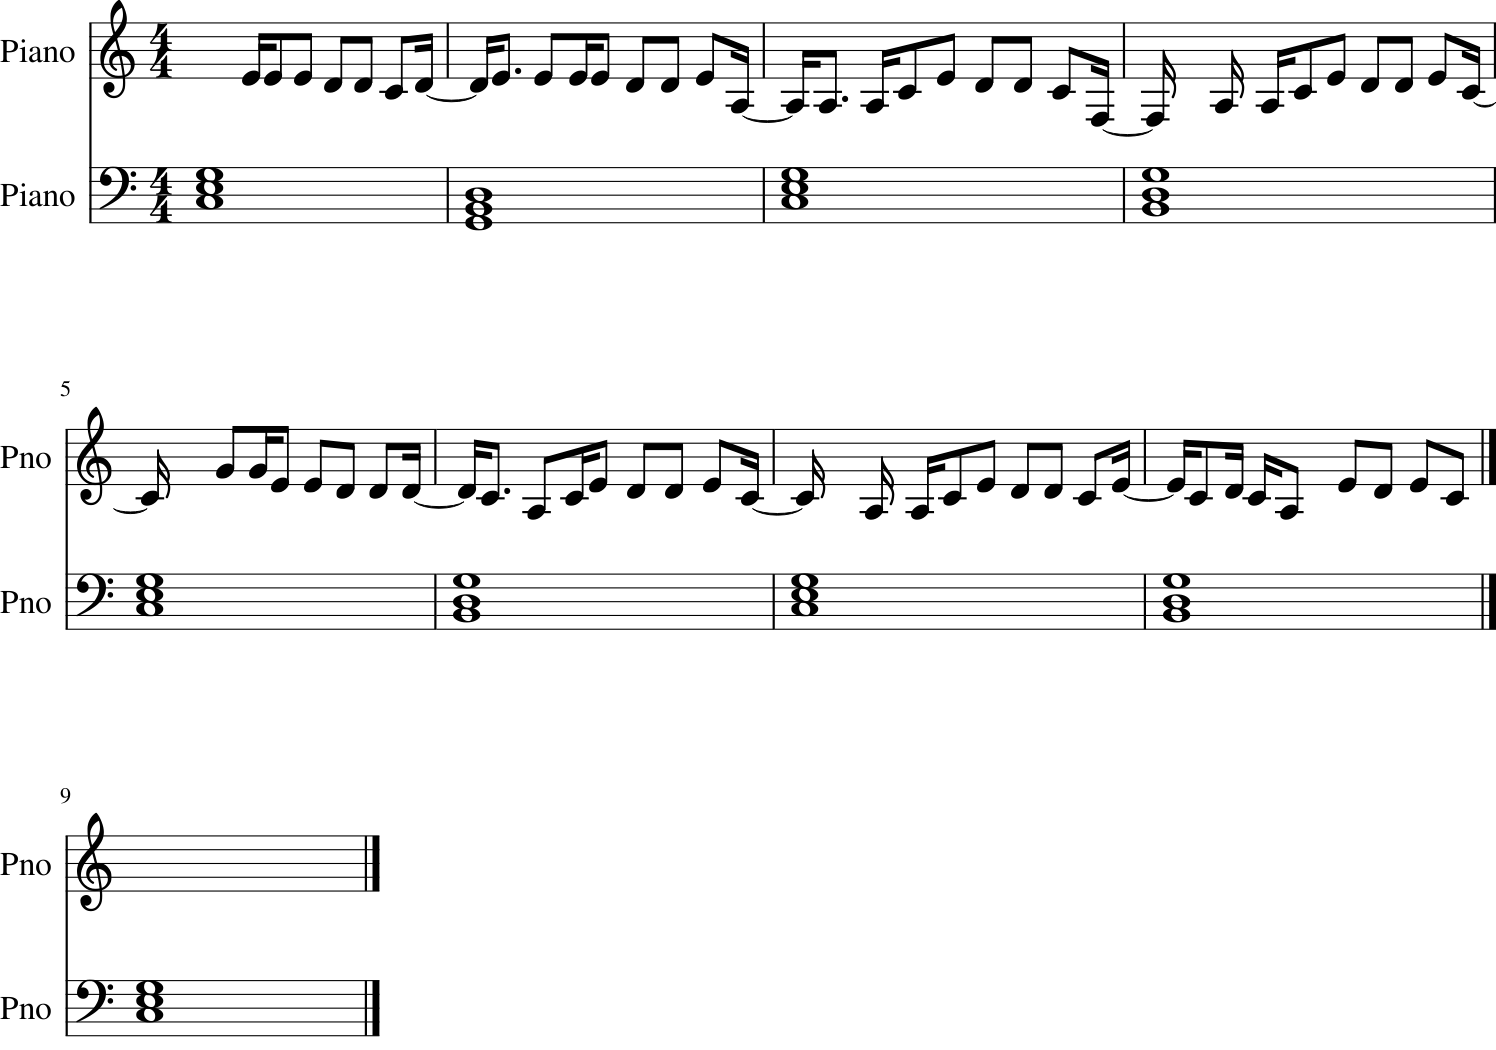

In [62]:
chordarr_comb = s2s_combine2chordarr(melody, out)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [63]:
comb_stream.show('midi')

In [64]:

def s2s_predict_from_midi(learn, midi=None, n_words=200, 
                      temperatures=(1.0,1.0), top_k=24, top_p=0.7, seed_len=None, pred_melody=True, **kwargs):
    mpart, cpart = midi_extract_melody_chords(midi)
    
    x_np, y_np = (cpart, mpart) if pred_melody else (mpart, cpart)
    
    # if seed_len is passed, cutoff sequence so we can predict the rest
    y_cut = y_np if seed_len is None else seed_tfm(y_np, seed_len=seed_len)
    
    x, y = torch.tensor(x_np), torch.tensor(y_cut)
    if torch.cuda.is_available(): x, y = x.cuda(), y.cuda()
    pred = learn.predict_s2s(x, y, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)

    part_order = [pred, cpart] if pred_melody else [mpart, cpart]
    chordarr_comb = s2s_combine2chordarr(*part_order)

    return chordarr_comb

In [65]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


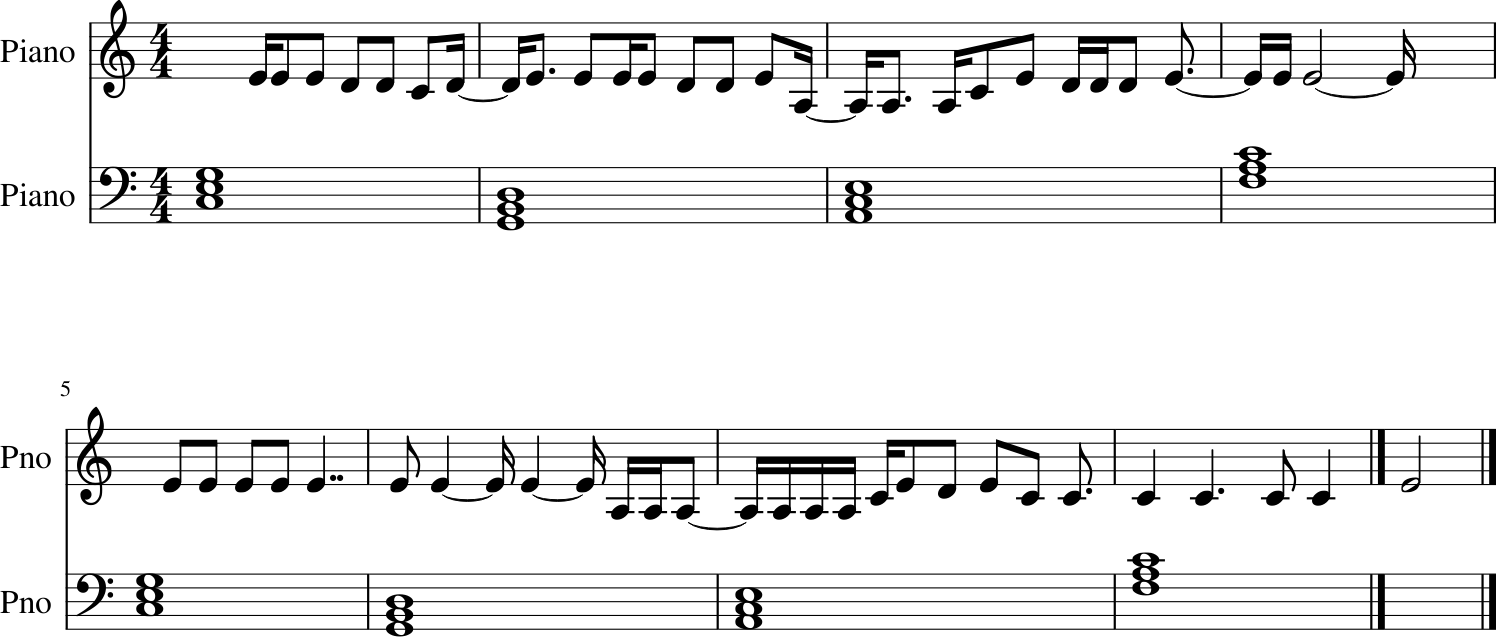

In [66]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()